In [46]:
from flytracker.preprocessing import construct_undistort_map, preprocessing
from flytracker.tracker import initialize, localize
from flytracker.tracking import blob_detector_localization, default_blob_detector_params, hungarian, localize_kmeans

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import numpy as np
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import k_means

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [48]:
def run(movie_path, mask, n_arenas, mapping_folder, n_frames=None, n_ini=100):
    """Custom run which returns raw numpy data"""
    # Constructing loader
    capture = cv.VideoCapture(movie_path)


    image_size = (
            int(capture.get(cv.CAP_PROP_FRAME_WIDTH)),
            int(capture.get(cv.CAP_PROP_FRAME_HEIGHT)),
        )
    mapping = construct_undistort_map(image_size, mapping_folder)

    loader = lambda: preprocessing(capture.read()[1], mapping=mapping, mask=mask)
    
    # Actual logic
    n_flies, initial_locations, initial_frame = initialize(loader, n_ini)
    locs = localize(loader, initial_locations, n_frames=n_frames)
    return locs

In [49]:
# Making mask
movie_path = "/home/gert-jan/Documents/flyTracker/data/testing_data/4arenas/seq_1.h264"
mapping_folder = "/home/gert-jan/Documents/flyTracker/data/distortion_maps/"

capture = cv.VideoCapture(movie_path)
image_size = (        int(capture.get(cv.CAP_PROP_FRAME_WIDTH)),
        int(capture.get(cv.CAP_PROP_FRAME_HEIGHT)),
    )
mapping = construct_undistort_map(image_size, mapping_folder)
image = lambda mask: preprocessing(capture.read()[1], mapping=mapping, mask=mask)

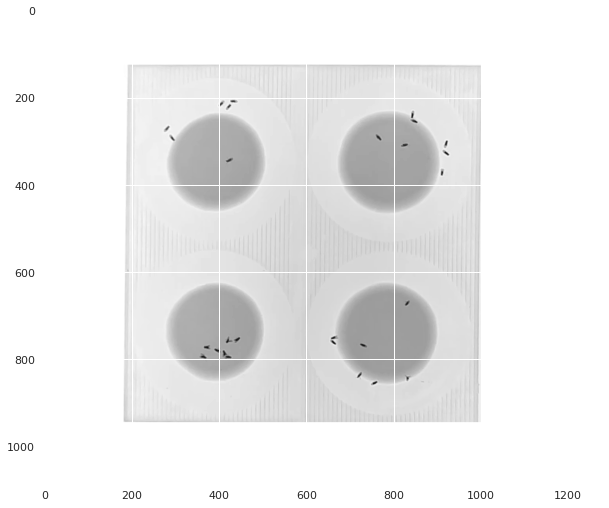

In [50]:
# Creating mask
mask = mask=np.ones(image_size, dtype=bool).T
mask[:125, :] = 0
mask[-135:, :] = 0
mask[:, :180] = 0
mask[:, -280:] = 0


plt.figure(figsize=(10, 10))
plt.imshow(image(mask), cmap='gray')

In [51]:
movie_path = "/home/gert-jan/Documents/flyTracker/data/testing_data/4arenas/seq_1.h264"
mapping_folder = "/home/gert-jan/Documents/flyTracker/data/distortion_maps/"
locs = run(movie_path, mask, n_arenas=4, mapping_folder=mapping_folder, n_frames=1000)

Done with frame 0


In [7]:
locations = locs
initial_frame = 100

In [8]:
# Getting some useful properties
n_frames = len(locations)
n_flies = len(locations[0])    

In [9]:
# finding identities and frames
identities = np.tile(np.arange(n_flies), n_frames)[:, None]
frames = np.repeat(np.arange(initial_frame, n_frames + initial_frame), n_flies)[:, None]

In [10]:
# Making dataframe
df = pd.DataFrame(np.concatenate([frames, identities], axis=1), columns=["frame", "ID"])
df[["x", "y"]] = np.concatenate(locations, axis=0)

In [11]:
df

,frame,ID,x,y
0,100,0,725.597351,844.902832
1,100,1,710.205750,834.727417
2,100,2,661.299072,762.019043
3,100,3,910.148926,373.796814
4,100,4,918.477234,344.859314
...,...,...,...,...
27022,1100,22,439.400000,229.857143
27023,1100,23,402.222222,236.138889
27024,1100,24,427.866667,242.000000
27025,1100,25,383.323529,224.588235


In [38]:
def find_arena(df, n_arenas):
    n_frames = df.frame.unique().size

    # Finding arenas and labels
    x_ave = df.pivot_table(index="ID", columns="frame", values="x").mean(axis=1)
    y_ave = df.pivot_table(index="ID", columns="frame", values="y").mean(axis=1)
    arena_centers, labels, _ = k_means(np.stack([x_ave, y_ave], axis=1), n_arenas)

    # Ordering arena centres left to right and modifying labels
    arena_centers = np.around(arena_centers, decimals=-2) # roughly same quarter
    ordering = np.lexsort((arena_centers[:, 0], arena_centers[:, 1]))
    ordering = [np.argmax(ordering == idx) for idx in np.arange(ordering.shape[0])]
    ordered_labels = [ordering[idx] for idx in labels]
    df["arena"] = np.tile(ordered_labels, n_frames)
    
    return df, arena_centers, labels

In [39]:
df, arena_centers, labels = find_arena(df, 4)

In [33]:
arena_centers
ordering = np.lexsort((arena_centers[:, 0], arena_centers[:, 1]))
print(arena_centers, ordering)

[[400. 800.]
 [400. 300.]
 [900. 300.]
 [700. 800.]] [1 2 0 3]


In [ ]:
0 -> 2
1 -> 0
2 -> 1
3 -> 3

[2, 0, 1, 3]

In [29]:
labels

array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 3, 3,
       3, 3, 3, 3, 3], dtype=int32)

In [40]:
def order_flies(df):
    # New ID's so flies [0, n_flies] are in arena 0
    # [n_flies, 2 x n_flies] in arena 1 etc.
    n_flies = df.ID.unique().size
    n_frames = df.frame.unique().size

    df = df.sort_values(by=["frame", "arena", "ID"])
    df["ID"] = np.tile(np.arange(n_flies), n_frames)
    df = df.sort_values(by=["frame", "ID"], ignore_index=True)

    return df

In [16]:
df = order_flies(df)

In [17]:
df

,frame,ID,x,y,arena
0,100,0,425.150085,348.581543,0
1,100,1,417.236603,204.828537,0
2,100,2,294.705261,301.618683,0
3,100,3,417.609772,223.885300,0
4,100,4,403.464752,215.709854,0
...,...,...,...,...,...
27022,1100,22,677.913043,770.934783,3
27023,1100,23,666.341463,781.268293,3
27024,1100,24,869.025641,846.923077,3
27025,1100,25,796.059701,680.343284,3


In [52]:
def post_process(locations, n_arenas, initial_frame):
    # Getting some useful properties
    n_frames = len(locations)
    n_flies = len(locations[0])    
    
    # finding identities and frames
    identities = np.tile(np.arange(n_flies), n_frames)[:, None]
    frames = np.repeat(np.arange(initial_frame, n_frames + initial_frame), n_flies)[:, None]
    
    # Making dataframe
    df = pd.DataFrame(np.concatenate([frames, identities], axis=1), columns=["frame", "ID"])
    df[["x", "y"]] = np.concatenate(locations, axis=0)
    
    # Adding arenas and reordering flies
    df = find_arena(df, n_arenas)
    df = order_flies(df)
    
    return df

def find_arena(df, n_arenas):
    n_frames = df.frame.unique().size

    # Finding arenas and labels
    x_ave = df.pivot_table(index="ID", columns="frame", values="x").mean(axis=1)
    y_ave = df.pivot_table(index="ID", columns="frame", values="y").mean(axis=1)
    arena_centers, labels, _ = k_means(np.stack([x_ave, y_ave], axis=1), n_arenas)

    # Ordering arena centres left to right and modifying labels
    arena_centers = np.around(arena_centers, decimals=-2) # roughly same quarter
    ordering = np.lexsort((arena_centers[:, 0], arena_centers[:, 1]))
    ordering = [np.argmax(ordering == idx) for idx in np.arange(ordering.shape[0])]
    ordered_labels = [ordering[idx] for idx in labels]
    df["arena"] = np.tile(ordered_labels, n_frames)
    
    return df

def order_flies(df):
    # New ID's so flies [0, n_flies] are in arena 0
    # [n_flies, 2 x n_flies] in arena 1 etc.
    n_flies = df.ID.unique().size
    n_frames = df.frame.unique().size

    df = df.sort_values(by=["frame", "arena", "ID"])
    df["ID"] = np.tile(np.arange(n_flies), n_frames)
    df = df.sort_values(by=["frame", "ID"], ignore_index=True)

    return df

In [53]:
df = post_process(locs, n_arenas=4, initial_frame=100)

In [54]:
df

,frame,ID,x,y,arena
0,100,0,425.150085,348.581543,0
1,100,1,417.236603,204.828537,0
2,100,2,294.705261,301.618683,0
3,100,3,417.609772,223.885300,0
4,100,4,403.464752,215.709854,0
...,...,...,...,...,...
27022,1100,22,677.913043,770.934783,3
27023,1100,23,666.341463,781.268293,3
27024,1100,24,869.025641,846.923077,3
27025,1100,25,796.059701,680.343284,3


<AxesSubplot:xlabel='x', ylabel='y'>

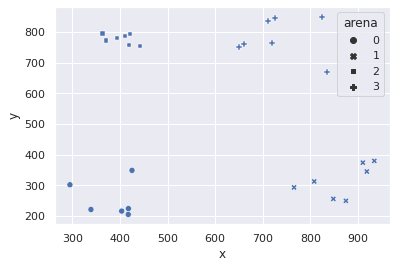

In [56]:
sns.scatterplot(data=df.query("frame == 100"), x="x", y="y", style="arena")

In [61]:
from flytracker.annotating import annotate

In [64]:
movie_path = "/home/gert-jan/Documents/flyTracker/data/testing_data/4arenas/seq_1.mp4"
annotate(df, movie_path, mapping_folder, 'annotated_video.mp4', max_frames=1000)

(1001, 27, 5)
Done with frame 1000


In [63]:
df

,frame,ID,x,y,arena
0,100,0,425.150085,348.581543,0
1,100,1,417.236603,204.828537,0
2,100,2,294.705261,301.618683,0
3,100,3,417.609772,223.885300,0
4,100,4,403.464752,215.709854,0
...,...,...,...,...,...
27022,1100,22,677.913043,770.934783,3
27023,1100,23,666.341463,781.268293,3
27024,1100,24,869.025641,846.923077,3
27025,1100,25,796.059701,680.343284,3
